In [1]:
#| default_exp models.deepar

# DeepAR

The DeepAR model produces probabilistic forecasts based on an autoregressive recurrent neural network optimized on panel data using cross-learning. DeepAR obtains its forecast distribution uses a Markov Chain Monte Carlo sampler with the following conditional probability:
$$\mathbb{P}(\mathbf{y}_{[t+1:t+H]}|\;\mathbf{y}_{[:t]},\; \mathbf{x}^{(f)}_{[:t+H]},\; \mathbf{x}^{(s)})$$

where $\mathbf{x}^{(s)}$ are static exogenous inputs, $\mathbf{x}^{(f)}_{[:t+H]}$ are future exogenous available at the time of the prediction.
The predictions are obtained by transforming the hidden states $\mathbf{h}_{t}$ into predictive distribution parameters $\theta_{t}$, and then generating samples $\mathbf{\hat{y}}_{[t+1:t+H]}$ through Monte Carlo sampling trajectories.

\begin{align}
\mathbf{h}_{t} &= \textrm{RNN}([\mathbf{y}_{t},\mathbf{x}^{(f)}_{t},\mathbf{x}^{(s)}], \mathbf{h}_{t-1})\\
\mathbf{\theta}_{t}&=\textrm{Linear}(\mathbf{h}_{t}) \\
\hat{y}_{t+1}&=\textrm{sample}(\;\mathrm{P}(y_{t+1}\;|\;\mathbf{\theta}_{t})\;)
\end{align}

**References**<br>
- [David Salinas, Valentin Flunkert, Jan Gasthaus, Tim Januschowski (2020). "DeepAR: Probabilistic forecasting with autoregressive recurrent networks". International Journal of Forecasting.](https://www.sciencedirect.com/science/article/pii/S0169207019301888)<br>
- [Alexander Alexandrov et. al (2020). "GluonTS: Probabilistic and Neural Time Series Modeling in Python". Journal of Machine Learning Research.](https://www.jmlr.org/papers/v21/19-820.html)<br>


:::{.callout-warning collapse="false"}
#### Exogenous Variables, Losses, and Parameters Availability

Given the sampling procedure during inference, DeepAR only supports `DistributionLoss` as training loss.

Note that DeepAR generates a non-parametric forecast distribution using Monte Carlo. We use this sampling procedure also during validation to make it closer to the inference procedure. Therefore, only the `MQLoss` is available for validation.

Aditionally, Monte Carlo implies that historic exogenous variables are not available for the model.
:::

![Figure 1. DeepAR model, during training the optimization signal comes from likelihood of observations, during inference a recurrent multi-step strategy is used to generate predictive distributions.](imgs_models/deepar.png)

In [2]:
#| export
import numpy as np

import torch
import torch.nn as nn

import logging
import warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

from typing import Optional

from neuralforecast.common._base_windows import BaseWindows
from neuralforecast.losses.pytorch import DistributionLoss, MQLoss

In [3]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

In [4]:
#| hide
import logging
import warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [5]:
#| export
class Decoder(nn.Module):
    """Multi-Layer Perceptron Decoder

    **Parameters:**<br>
    `in_features`: int, dimension of input.<br>
    `out_features`: int, dimension of output.<br>
    `hidden_size`: int, dimension of hidden layers.<br>
    `num_layers`: int, number of hidden layers.<br>
    """

    def __init__(self, in_features, out_features, hidden_size, hidden_layers):
        super().__init__()

        if hidden_layers == 0:
            # Input layer
            layers = [nn.Linear(in_features=in_features, out_features=out_features)]
        else:
            # Input layer
            layers = [nn.Linear(in_features=in_features, out_features=hidden_size), nn.ReLU()]
            # Hidden layers
            for i in range(hidden_layers - 2):
                layers += [nn.Linear(in_features=hidden_size, out_features=hidden_size), nn.ReLU()]
            # Output layer
            layers += [nn.Linear(in_features=hidden_size, out_features=out_features)]

        # Store in layers as ModuleList
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [6]:
#| export
class DeepAR(BaseWindows):
    """ DeepAR

    The DeepAR model produces probabilistic forecasts based on an autoregressive recurrent neural network optimized on panel data using cross-learning. DeepAR obtains its forecast distribution uses a Markov Chain Monte Carlo sampler with the following conditional probability:
    $$\mathbb{P}(\mathbf{y}_{[t+1:t+H]}|\;\mathbf{y}_{[:t]},\; \mathbf{x}^{(f)}_{[:t+H]},\; \mathbf{x}^{(s)})$$

    where $\mathbf{x}^{(s)}$ are static exogenous inputs, $\mathbf{x}^{(f)}_{[:t+H]}$ are future exogenous available at the time of the prediction.
    The predictions are obtained by transforming the hidden states $\mathbf{h}_{t}$ into predictive distribution parameters $\theta_{t}$, and then generating samples $\mathbf{\hat{y}}_{[t+1:t+H]}$ through Monte Carlo sampling trajectories.

    \begin{align}
    \mathbf{h}_{t} &= \textrm{RNN}([\mathbf{y}_{t},\mathbf{x}^{(f)}_{t},\mathbf{x}^{(s)}], \mathbf{h}_{t-1})\\
    \mathbf{\theta}_{t}&=\textrm{Linear}(\mathbf{h}_{t}) \\
    \hat{y}_{t+1}&=\textrm{sample}(\;\mathrm{P}(y_{t+1}\;|\;\mathbf{\theta}_{t})\;)
    \end{align}

    **References**<br>
    - [David Salinas, Valentin Flunkert, Jan Gasthaus, Tim Januschowski (2020). "DeepAR: Probabilistic forecasting with autoregressive recurrent networks". International Journal of Forecasting.](https://www.sciencedirect.com/science/article/pii/S0169207019301888)<br>
    - [Alexander Alexandrov et. al (2020). "GluonTS: Probabilistic and Neural Time Series Modeling in Python". Journal of Machine Learning Research.](https://www.jmlr.org/papers/v21/19-820.html)<br>

    """
    # Class attributes
    SAMPLING_TYPE = 'windows'
    
    def __init__(self,
                 h,
                 input_size: int = -1,
                 lstm_n_layers: int=2,
                 lstm_hidden_size: int = 128,
                 lstm_dropout: float = 0.1,
                 decoder_hidden_layers: int = 0,
                 decoder_hidden_size: int = 0,
                 trajectory_samples: int = 100,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 exclude_insample_y = False,
                 loss = DistributionLoss(distribution='StudentT', level=[80, 90], return_params=False),
                 valid_loss = MQLoss(level=[80, 90]),
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = 3,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size: int = 1024,
                 inference_windows_batch_size: int = -1,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 num_workers_loader = 0,
                 drop_last_loader = False,
                 **trainer_kwargs):

        # DeepAR does not support historic exogenous variables
        if hist_exog_list is not None:
            raise Exception('DeepAR does not support historic exogenous variables.')

        if exclude_insample_y:
            raise Exception('DeepAR has no possibility for excluding y.')
        
        if not loss.is_distribution_output:
            raise Exception('DeepAR only supports distributional outputs.')
        
        if str(type(valid_loss)) not in ["<class 'neuralforecast.losses.pytorch.MQLoss'>"]:
            raise Exception('DeepAR only supports MQLoss as validation loss.')

        if loss.return_params:
            raise Exception('DeepAR does not return distribution parameters due to Monte Carlo sampling.')
    
        # Inherit BaseWindows class
        super(DeepAR, self).__init__(h=h,
                                    input_size=input_size,
                                    futr_exog_list=futr_exog_list,
                                    hist_exog_list=hist_exog_list,
                                    stat_exog_list=stat_exog_list,
                                    exclude_insample_y = exclude_insample_y,
                                    loss=loss,
                                    valid_loss=valid_loss,
                                    max_steps=max_steps,
                                    learning_rate=learning_rate,
                                    num_lr_decays=num_lr_decays,
                                    early_stop_patience_steps=early_stop_patience_steps,
                                    val_check_steps=val_check_steps,
                                    batch_size=batch_size,
                                    windows_batch_size=windows_batch_size,
                                    valid_batch_size=valid_batch_size,
                                    inference_windows_batch_size=inference_windows_batch_size,
                                    step_size=step_size,
                                    scaler_type=scaler_type,
                                    num_workers_loader=num_workers_loader,
                                    drop_last_loader=drop_last_loader,
                                    random_seed=random_seed,
                                    **trainer_kwargs)

        self.horizon_backup = self.h # Used because h=0 during training
        self.trajectory_samples = trajectory_samples

        # LSTM
        self.encoder_n_layers = lstm_n_layers
        self.encoder_hidden_size = lstm_hidden_size
        self.encoder_dropout = lstm_dropout

        self.futr_exog_size = len(self.futr_exog_list)
        self.hist_exog_size = 0
        self.stat_exog_size = len(self.stat_exog_list)
        
        # LSTM input size (1 for target variable y)
        input_encoder = 1 + self.futr_exog_size + self.stat_exog_size

        # Instantiate model
        self.hist_encoder = nn.LSTM(input_size=input_encoder,
                                    hidden_size=self.encoder_hidden_size,
                                    num_layers=self.encoder_n_layers,
                                    dropout=self.encoder_dropout,
                                    batch_first=True)

        # Decoder MLP
        self.decoder = Decoder(in_features=lstm_hidden_size,
                               out_features=self.loss.outputsize_multiplier,
                               hidden_size=decoder_hidden_size,
                               hidden_layers=decoder_hidden_layers)

    # Override BaseWindows method
    def training_step(self, batch, batch_idx):

        # During training h=0  
        self.h = 0

        # Create and normalize windows [Ws, L, C]
        windows = self._create_windows(batch, step='train')
        original_insample_y = windows['temporal'][:, :, 0].clone() # windows: [B, L, Feature] -> [B, L]
        original_insample_y = original_insample_y[:,1:] # Remove first (shift in DeepAr, cell at t outputs t+1)
        windows = self._normalization(windows=windows)

        # Parse windows
        insample_y, insample_mask, _, _, _, futr_exog, stat_exog = self._parse_windows(batch, windows)

        windows_batch = dict(insample_y=insample_y, # [Ws, L]
                             insample_mask=insample_mask, # [Ws, L]
                             futr_exog=futr_exog, # [Ws, L+H]
                             hist_exog=None, # None
                             stat_exog=stat_exog) # [Ws, 1]

        # Model Predictions
        output = self.train_forward(windows_batch)

        if self.loss.is_distribution_output:
            _, y_loc, y_scale = self._inv_normalization(y_hat=original_insample_y,
                                            temporal_cols=batch['temporal_cols'])
            outsample_y = original_insample_y
            distr_args = self.loss.scale_decouple(output=output, loc=y_loc, scale=y_scale)
            mask = insample_mask[:,1:].clone() # Remove first (shift in DeepAr, cell at t outputs t+1)
            loss = self.loss(y=outsample_y, distr_args=distr_args, mask=mask)
        else:
            raise Exception('DeepAR only supports distributional outputs.')

        if torch.isnan(loss):
            print('Model Parameters', self.hparams)
            print('insample_y', torch.isnan(insample_y).sum())
            print('outsample_y', torch.isnan(outsample_y).sum())
            print('output', torch.isnan(output).sum())
            raise Exception('Loss is NaN, training stopped.')

        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        self.train_trajectories.append((self.global_step, float(loss)))

        self.h = self.horizon_backup # Restore horizon
        return loss

    def validation_step(self, batch, batch_idx):

        self.h == self.horizon_backup

        if self.val_size == 0:
            return np.nan

        # TODO: Hack to compute number of windows
        windows = self._create_windows(batch, step='val')
        n_windows = len(windows['temporal'])

        # Number of windows in batch
        windows_batch_size = self.inference_windows_batch_size
        if windows_batch_size < 0:
            windows_batch_size = n_windows
        n_batches = int(np.ceil(n_windows/windows_batch_size))

        valid_losses = []
        batch_sizes = []
        for i in range(n_batches):
            # Create and normalize windows [Ws, L+H, C]
            w_idxs = np.arange(i*windows_batch_size, 
                               min((i+1)*windows_batch_size, n_windows))
            windows = self._create_windows(batch, step='val', w_idxs=w_idxs)
            original_outsample_y = torch.clone(windows['temporal'][:,-self.h:,0])
            windows = self._normalization(windows=windows)

            # Parse windows
            insample_y, insample_mask, _, outsample_mask, \
                _, futr_exog, stat_exog = self._parse_windows(batch, windows)
            windows_batch = dict(insample_y=insample_y,
                        insample_mask=insample_mask,
                        futr_exog=futr_exog,
                        hist_exog=None,
                        stat_exog=stat_exog,
                        temporal_cols=batch['temporal_cols']) 
            
            # Model Predictions
            output_batch = self(windows_batch)
            # Monte Carlo already returns y_hat with mean and quantiles
            output_batch = output_batch[:,:, 1:] # Remove mean
            valid_loss_batch = self.valid_loss(y=original_outsample_y, y_hat=output_batch, mask=outsample_mask)
            valid_losses.append(valid_loss_batch)
            batch_sizes.append(len(output_batch))

        valid_loss = torch.stack(valid_losses)
        batch_sizes = torch.tensor(batch_sizes).to(valid_loss.device)
        valid_loss = torch.sum(valid_loss * batch_sizes) \
                        / torch.sum(batch_sizes)

        if torch.isnan(valid_loss):
            raise Exception('Loss is NaN, training stopped.')

        self.log('valid_loss', valid_loss, prog_bar=True, on_epoch=True)
        self.validation_step_outputs.append(valid_loss)
        return valid_loss

    def predict_step(self, batch, batch_idx):

        self.h == self.horizon_backup

        # TODO: Hack to compute number of windows
        windows = self._create_windows(batch, step='predict')
        n_windows = len(windows['temporal'])

        # Number of windows in batch
        windows_batch_size = self.inference_windows_batch_size
        if windows_batch_size < 0:
            windows_batch_size = n_windows
        n_batches = int(np.ceil(n_windows/windows_batch_size))

        y_hats = []
        for i in range(n_batches):
            # Create and normalize windows [Ws, L+H, C]
            w_idxs = np.arange(i*windows_batch_size, 
                    min((i+1)*windows_batch_size, n_windows))
            windows = self._create_windows(batch, step='predict', w_idxs=w_idxs)
            windows = self._normalization(windows=windows)

            # Parse windows
            insample_y, insample_mask, _, _, _, futr_exog, stat_exog = self._parse_windows(batch, windows)
            windows_batch = dict(insample_y=insample_y, # [Ws, L]
                                insample_mask=insample_mask, # [Ws, L]
                                futr_exog=futr_exog, # [Ws, L+H]
                                stat_exog=stat_exog,
                                temporal_cols=batch['temporal_cols']) 
            
            # Model Predictions
            y_hat = self(windows_batch)
            # Monte Carlo already returns y_hat with mean and quantiles
            y_hats.append(y_hat)
        y_hat = torch.cat(y_hats, dim=0)
        return y_hat

    def train_forward(self, windows_batch):

        # Parse windows_batch
        encoder_input = windows_batch['insample_y'][:,:, None] # <- [B,T,1]
        futr_exog  = windows_batch['futr_exog']
        stat_exog  = windows_batch['stat_exog']

        #[B, seq_len, X]
        _, input_size = encoder_input.shape[:2]
        if self.futr_exog_size > 0:
            # Remove last and shift futr_exog (t predicts t+1, last output is outside insample_y)
            encoder_input = torch.cat((encoder_input[:,:-1,:], futr_exog[:,1:,:]), dim=2)
        if self.stat_exog_size > 0:
            stat_exog = stat_exog.unsqueeze(1).repeat(1, input_size-1, 1) # [B, S] -> [B, input_size-1, S]
            encoder_input = torch.cat((encoder_input, stat_exog), dim=2)

        # RNN forward
        hidden_state, _ = self.hist_encoder(encoder_input) # [B, input_size-1, rnn_hidden_state]

        # Decoder forward
        output = self.decoder(hidden_state) # [B, input_size-1, output_size]
        output = self.loss.domain_map(output)
        return output
    
    def forward(self, windows_batch):

        # Parse windows_batch
        encoder_input = windows_batch['insample_y'][:,:, None] # <- [B,L,1]
        futr_exog  = windows_batch['futr_exog'] # <- [B,L+H, n_f]
        stat_exog  = windows_batch['stat_exog']
        temporal_cols = windows_batch['temporal_cols']

        #[B, seq_len, X]
        batch_size, input_size = encoder_input.shape[:2]
        if self.futr_exog_size > 0:
            futr_exog_input_window = futr_exog[:,1:input_size+1,:] # Align y_t with futr_exog_t+1
            encoder_input = torch.cat((encoder_input, futr_exog_input_window), dim=2)
        if self.stat_exog_size > 0:
            stat_exog_input_window = stat_exog.unsqueeze(1).repeat(1, input_size, 1) # [B, S] -> [B, input_size, S]
            encoder_input = torch.cat((encoder_input, stat_exog_input_window), dim=2)

        # Use input_size history to predict first h of the forecasting window
        _, h_c_tuple = self.hist_encoder(encoder_input)
        h_n = h_c_tuple[0] # [n_layers, B, lstm_hidden_state]
        c_n = h_c_tuple[1] # [n_layers, B, lstm_hidden_state]

        # Vectorizes trajectory samples in batch dimension [1]
        h_n = torch.repeat_interleave(h_n, self.trajectory_samples, 1) # [n_layers, B*trajectory_samples, rnn_hidden_state]
        c_n = torch.repeat_interleave(c_n, self.trajectory_samples, 1) # [n_layers, B*trajectory_samples, rnn_hidden_state]

        # Scales for inverse normalization
        y_scale = self.scaler.x_scale[:,0,temporal_cols.get_indexer(['y'])].squeeze(-1)
        y_loc = self.scaler.x_shift[:,0,temporal_cols.get_indexer(['y'])].squeeze(-1)
        y_scale = torch.repeat_interleave(y_scale, self.trajectory_samples, 0)
        y_loc = torch.repeat_interleave(y_loc, self.trajectory_samples, 0)

        # Recursive strategy prediction
        quantiles = self.loss.quantiles.to(encoder_input.device)
        y_hat = torch.zeros(batch_size, self.h, len(quantiles)+1)
        for tau in range(self.h):
            # Decoder forward
            last_layer_h = h_n[-1] # [B*trajectory_samples, lstm_hidden_state]
            output = self.decoder(last_layer_h) 
            output = self.loss.domain_map(output)

            # Inverse normalization
            distr_args = self.loss.scale_decouple(output=output, loc=y_loc, scale=y_scale)
            # Add horizon (1) dimension
            distr_args = list(distr_args)
            for i in range(len(distr_args)):
                distr_args[i] = distr_args[i].unsqueeze(-1)
            distr_args = tuple(distr_args)
            samples_tau, _, _ = self.loss.sample(distr_args=distr_args, num_samples=1)
            samples_tau = samples_tau.reshape(batch_size, self.trajectory_samples)
            sample_mean = torch.mean(samples_tau, dim=-1)
            quants = torch.quantile(input=samples_tau, 
                                    q=quantiles, dim=-1)
            y_hat[:,tau,0] = sample_mean
            y_hat[:,tau,1:] = quants.permute((1,0)) # [Q, B] -> [B, Q]
            
            # Stop if already in the last step (no need to predict next step)
            if tau+1 == self.h:
                continue
            # Normalize to use as input
            encoder_input = self.scaler.scaler(samples_tau.flatten(), y_loc, y_scale) # [B*n_samples]
            encoder_input = encoder_input[:, None, None] # [B*n_samples, 1, 1]

            # Update input
            if self.futr_exog_size > 0:
                futr_exog_tau = futr_exog[:,[input_size+tau+1],:] # [B, 1, n_f]
                futr_exog_tau = torch.repeat_interleave(futr_exog_tau, self.trajectory_samples, 0) # [B*n_samples, 1, n_f]
                encoder_input = torch.cat((encoder_input, futr_exog_tau), dim=2) # [B*n_samples, 1, 1+n_f]
            if self.stat_exog_size > 0:
                stat_exog_tau = torch.repeat_interleave(stat_exog, self.trajectory_samples, 0) # [B*n_samples, n_s]
                encoder_input = torch.cat((encoder_input, stat_exog_tau[:,None,:]), dim=2) # [B*n_samples, 1, 1+n_f+n_s]
            
            _, h_c_tuple = self.hist_encoder(encoder_input, (h_n, c_n))
            h_n = h_c_tuple[0] # [n_layers, B, rnn_hidden_state]
            c_n = h_c_tuple[1] # [n_layers, B, rnn_hidden_state]

        return y_hat

In [7]:
show_doc(DeepAR, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/deepar.py#L62){target="_blank" style="float:right; font-size:smaller"}

### DeepAR

>      DeepAR (h, input_size:int=-1, lstm_n_layers:int=2,
>              lstm_hidden_size:int=128, lstm_dropout:float=0.1,
>              decoder_hidden_layers:int=0, decoder_hidden_size:int=0,
>              trajectory_samples:int=100, futr_exog_list=None,
>              hist_exog_list=None, stat_exog_list=None,
>              exclude_insample_y=False, loss=DistributionLoss(),
>              valid_loss=MQLoss(), max_steps:int=1000,
>              learning_rate:float=0.001, num_lr_decays:int=3,
>              early_stop_patience_steps:int=-1, val_check_steps:int=100,
>              batch_size:int=32, valid_batch_size:Optional[int]=None,
>              windows_batch_size:int=1024, inference_windows_batch_size:int=-1,
>              step_size:int=1, scaler_type:str='identity', random_seed:int=1,
>              num_workers_loader=0, drop_last_loader=False, **trainer_kwargs)

DeepAR

The DeepAR model produces probabilistic forecasts based on an autoregressive recurrent neural network optimized on panel data using cross-learning. DeepAR obtains its forecast distribution uses a Markov Chain Monte Carlo sampler with the following conditional probability:
$$\mathbb{P}(\mathbf{y}_{[t+1:t+H]}|\;\mathbf{y}_{[:t]},\; \mathbf{x}^{(f)}_{[:t+H]},\; \mathbf{x}^{(s)})$$

where $\mathbf{x}^{(s)}$ are static exogenous inputs, $\mathbf{x}^{(f)}_{[:t+H]}$ are future exogenous available at the time of the prediction.
The predictions are obtained by transforming the hidden states $\mathbf{h}_{t}$ into predictive distribution parameters $   heta_{t}$, and then generating samples $\mathbf{\hat{y}}_{[t+1:t+H]}$ through Monte Carlo sampling trajectories.

egin{align}
\mathbf{h}_{t} &=   extrm{RNN}([\mathbf{y}_{t},\mathbf{x}^{(f)}_{t},\mathbf{x}^{(s)}], \mathbf{h}_{t-1})\
\mathbf{    heta}_{t}&=     extrm{Linear}(\mathbf{h}_{t}) \
\hat{y}_{t+1}&=     extrm{sample}(\;\mathrm{P}(y_{t+1}\;|\;\mathbf{ heta}_{t})\;)
\end{align}

**References**<br>
- [David Salinas, Valentin Flunkert, Jan Gasthaus, Tim Januschowski (2020). "DeepAR: Probabilistic forecasting with autoregressive recurrent networks". International Journal of Forecasting.](https://www.sciencedirect.com/science/article/pii/S0169207019301888)<br>
- [Alexander Alexandrov et. al (2020). "GluonTS: Probabilistic and Neural Time Series Modeling in Python". Journal of Machine Learning Research.](https://www.jmlr.org/papers/v21/19-820.html)<br>

In [8]:
show_doc(DeepAR.fit, name='DeepAR.fit', title_level=3)

---

### DeepAR.fit

>      DeepAR.fit (dataset, val_size=0, test_size=0, random_seed=None)

Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`test_size`: int, test size for temporal cross-validation.<br>

In [9]:
show_doc(DeepAR.predict, name='DeepAR.predict', title_level=3)

---

### DeepAR.predict

>      DeepAR.predict (dataset, test_size=None, step_size=1, random_seed=None,
>                      **data_module_kwargs)

Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).

## Usage Example

In [10]:
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, PMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

Global seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.38it/s]


[]

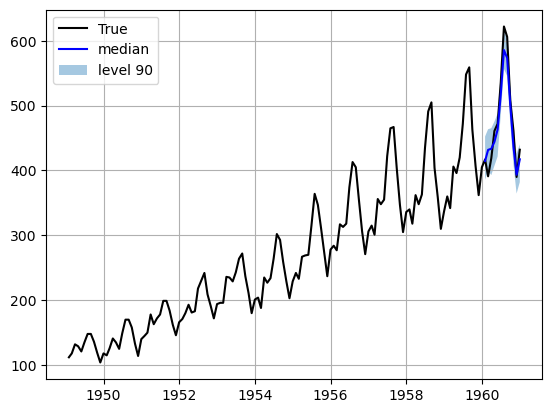

In [11]:
#| eval: false
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
#from neuralforecast.models import DeepAR
from neuralforecast.losses.pytorch import DistributionLoss, HuberMQLoss
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

#AirPassengersPanel['y'] = AirPassengersPanel['y'] + 10
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

nf = NeuralForecast(
    models=[DeepAR(h=12,
                   input_size=48,
                   lstm_n_layers=3,
                   trajectory_samples=100,
                   loss=DistributionLoss(distribution='Normal', level=[80, 90], return_params=False),
                   learning_rate=0.005,
                   stat_exog_list=['airline1'],
                   futr_exog_list=['trend'],
                   max_steps=100,
                   val_check_steps=10,
                   early_stop_patience_steps=-1,
                   scaler_type='standard',
                   enable_progress_bar=True),
    ],
    freq='M'
)
nf.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
Y_hat_df = nf.predict(futr_df=Y_test_df)

# Plot quantile predictions
Y_hat_df = Y_hat_df.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
#plt.plot(plot_df['ds'], plot_df['DeepAR'], c='purple', label='mean')
plt.plot(plot_df['ds'], plot_df['DeepAR-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:], 
                 y1=plot_df['DeepAR-lo-90'][-12:].values, 
                 y2=plot_df['DeepAR-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()